## Homework - PROJECT 3:

As your homework, you will use a `Cellcharter` to compute the cellular neighborhood representation, and later - analyze them. The task is inspired by [this](https://cellcharter.readthedocs.io/en/stable/notebooks/cosmx_human_nsclc.html) tutorial, so we highly recommend to go through it before jumping into coding the solution.

Your task consists of the following step:
- (warm up) - once again perform a `PCA` on cells marker expressions. Your `PCA` should explain 95% of markers variance. Store a `PCA` transformed marker expressions in `train_anndata.obsm["X_PCA"]` field (note: this is equivalent to `"X_SCVI"` field from the tutorial) - 1pt,
- perform a `cellcharter` neighbor aggregation using [this](https://cellcharter.readthedocs.io/en/latest/generated/cellcharter.gr.aggregate_neighbors.html#cellcharter.gr.aggregate_neighbors) function (hint: `sample_key` for our data is `sample_id`). Select `n_layers` parameter value on your own, but shortly explain your choice - 2pts,
- perform a cluster selection in the same manner as for mean marker and cell type histogram representation - 2pts,
- perform a `PCA`, celltype abundance and mean marker analysis in the same manner as for mean marker and cell type histogram representations - 3pts,
- for each pair of the clusterings out of mean marker, cell type histogram and cellcharter-based ones, compute a cross-count matrix (a cross-count matrix stores the information about how many times each cell was assigned to a predefined pair of clusters from every modality). Visualize these matrices and briefly explain the results - 2pts.

In this task you do not need to prepare a proper report, inline comments in the notebook are sufficient. However, make sure that you comment on any of the steps, decisions or results. As usual, we want to make sure that we are able _to understand_ our results.

The deadline for the task: 12th May, 12:00 (noon)
Have fun!


# Warm-up

Let's start by installing the `Cellcharter` and `Squidpy` packages, importing the necessary libraries and downloading the data on which we will perform all our analyses. We will start by performing **PCA** on cells' marker expression that will explain 95% of the variance. We are going to contain the obtained results in a field named *train_anndata.obsm['X_PCA']*.

In [1]:
!pip install squidpy
!pip install cellcharter
!pip install lightning

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.3/161.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 117.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [2]:
# Restart session
exit()

In [10]:
import gc
import anndata

import squidpy as sq
import cellcharter as cc

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from lightning.pytorch import seed_everything
from scipy.sparse.csgraph import connected_components

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
TRAIN_ANNDATA_PATH = '/content/drive/MyDrive/data/train_adata.h5ad'

seed_everything(42)
sns.set_theme()
plt.rcParams['figure.figsize'] = (12, 9)

train_anndata = anndata.read_h5ad(TRAIN_ANNDATA_PATH)
print(train_anndata)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Mounted at /content/drive


In [3]:
# Standardisation for PCA on cells' marker expression
expressions = train_anndata.layers['exprs']  # tuple of 253433 cells
total_counts = expressions.sum(axis=1, keepdims=True)
norm_exprs = (expressions / total_counts) * 1e6
norm_exprs = np.log1p(norm_exprs)
train_anndata.layers['normalised_exprs'] = norm_exprs

# PCA explaining 95% of variance
pca = PCA(n_components=0.95, svd_solver='full')
pca_exprs = pca.fit_transform(norm_exprs)
print(f"PCA: Number of components = {pca_exprs.shape[1]}, Explained variance = {pca.explained_variance_ratio_.sum():.2f}")

# Store in obsm
train_anndata.obsm['X_PCA'] = pca_exprs

PCA: Number of components = 25, Explained variance = 0.95


In [4]:
def plot_clustermap(data: pd.DataFrame,
                    x_labels: pd.DataFrame,
                    shape: int,
                    title: str) -> None:
    """ Helper function for plotting clustermap.
    """
    plot = sns.clustermap(
        data,
        cmap='seismic',
        center=0.0,
        xticklabels=x_labels,
        yticklabels=[f"PC{idx+1}" for idx in range(shape)],
        figsize=plt.rcParams['figure.figsize'],
    )

    # Improved layout for the plot
    cbar = plot.ax_heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12,
                        pad=0.10,
                        labelleft=True,
                        labelright=False,
                        left=True,
                        right=False
    )

    plot.ax_heatmap.set_xlabel('Markers', fontsize=16, labelpad=8)
    plot.ax_heatmap.set_ylabel('Principal Components', fontsize=16, labelpad=8)
    plt.title(title, fontsize=16, pad=16, loc='center', weight='bold')
    plt.tight_layout()
    plt.show()
    plt.close()

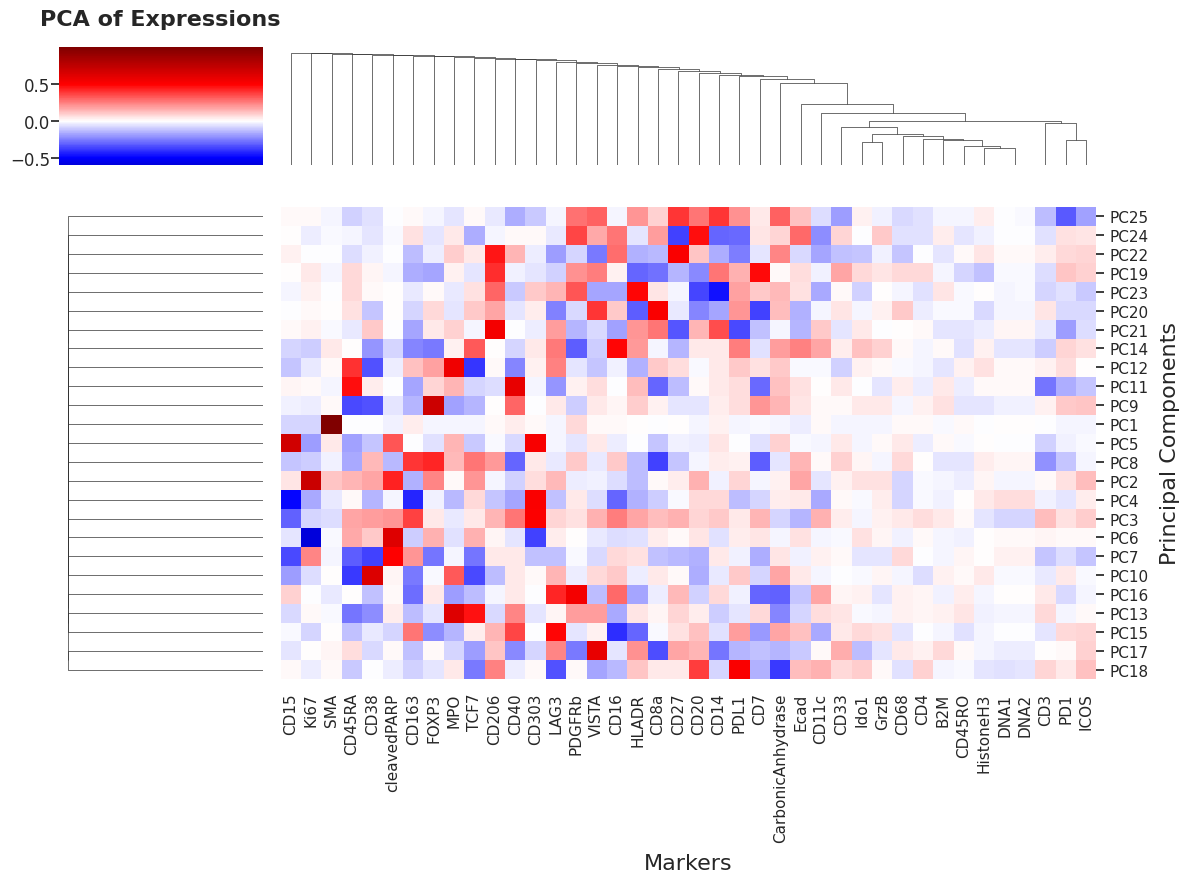

In [5]:
plot_clustermap(pca.components_,
                train_anndata.var['marker'],
                pca_exprs.shape[1],
                'PCA of Expressions'
)

As shown in the clustermap above, there are markers that have a marginal effect on each of the PCA components explaining the variance in our data (they do not explain the variation in our data, for example **DNA1** and **DNA2**, which are fluorescent pigments or probes that bind directly to deoxyribonucleic acid (DNA) in the cell nucleus), but we also have markers that strongly differentiate the cells analysed (e.g. **CD** markers, which are immune system cell surface proteins that are responsible for the distribution of specific immune populations in relation to each other).

# Neighbourhood Aggregation

In [6]:
train_anndata.obsm['spatial'] = train_anndata.obs[['Pos_X', 'Pos_Y']].values

sq.gr.spatial_neighbors(
    train_anndata,
    library_key='sample_id',
    coord_type='generic',
    delaunay=True,
    spatial_key='spatial',
    percentile=99,
)

In [11]:
n_origin, _ = connected_components(train_anndata.obsp['spatial_connectivities'])
print(f"Componets of original graph: {n_origin}")

Componets of original graph: 138


In [ ]:
"""
adj = train_anndata.obsp['spatial_connectivities']
dist = train_anndata.obsp['spatial_distances']
thr = np.percentile(dist.data, 99)
mask = dist.data <= thr
adj.data = adj.data * mask
adj.eliminate_zeros()
n_comp, _ = connected_components(adj)
print(f"Components of adjusted graph: {n_comp}")
"""

Components of adjusted graph: 280


In [12]:
# Neighbor Aggregation
cc.gr.aggregate_neighbors(
    train_anndata,
    n_layers=3, # as in the tutorial
    use_rep='X_PCA',
    out_key='X_cellcharter',
    sample_key='sample_id'
)

  0%|          | 0/132 [00:00<?, ?it/s]

(253433, 25)
(253433, 100)


/usr/local/lib/python3.11/dist-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


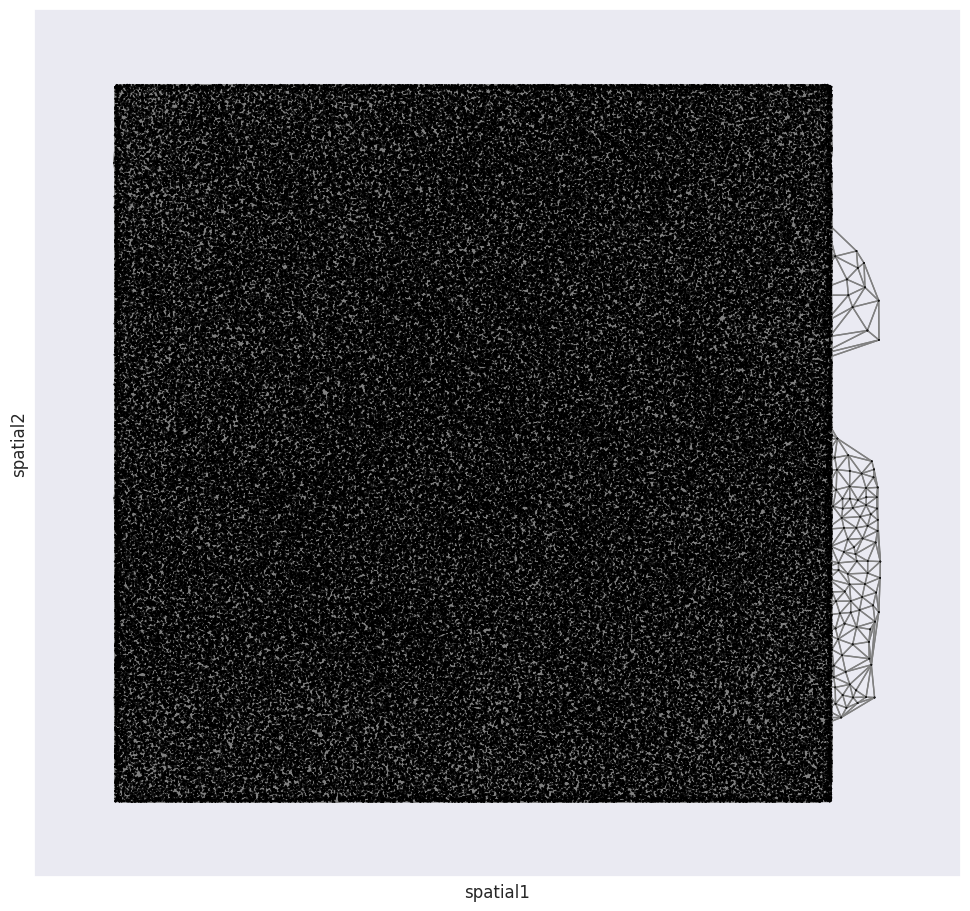

In [14]:
# Checking the dimensions
print(train_anndata.obsm['X_PCA'].shape)
print(train_anndata.obsm['X_cellcharter'].shape)

# Visualising the neighbourhood
sq.pl.spatial_scatter(train_anndata,
                      shape=None,
                      connectivity_key='spatial_connectivities'
)

We first created a spatial graph in Squidpy using Delaunay triangulation, which automatically connects neighbouring cells. It groups cells by sample (`sample_id` column), and then we convert the distances into a binary matrix (1 = connect, 0 = none). We then check that our graph is consistent, which results in a check that our neighbourhood graph consists of 138 consistent components. In the next step we check how their number is affected by removing connections longer than the 99th percentile of the distances. However, the number of coherent components increases significantly (up to 280), so we abandon this idea due to the violation of the coherence of the graph. We then performed data aggregation using **n_layers=3** to maintain a trade-off between the local and wide neighbourhood of the cell. In this way, we average the marker vectors from the neighbourhood of the specified layer (1 - denotes immediate neighbours). It is worth noting that there are many isolated groups of cells in our data.

# Cluster Selection

Now, using *Gaussian Mixture Clustering* and assessing the stability/repeatability of the results, we will find the optimal number of clusters (**best_k**) for the analysed data. To speed up the computation, we will limit ourselves to 8 independent replicates and train our **ClusterAutoK** model on every 10 observations, which significantly reduces the computation time while maintaining the representativeness of the distribution.

In [15]:
# Defining params for AutoK model to find best candidate for the number of clusters
n_clusters = range(4,32)
model_params = {
        'random_state': 42,
        'trainer_params': {
            'accelerator':'gpu',
            'enable_progress_bar': False
        },
}

model = cc.tl.ClusterAutoK(n_clusters=n_clusters,
                           model_class=cc.tl.GaussianMixture,
                           model_params=model_params,
                           max_runs=8
)

# Change to float32 for compatibility of numpy and torch calculations
train_anndata.obsm["X_cellcharter"] = train_anndata.obsm["X_cellcharter"].astype(np.float32)

# Taking every 10th example to expedite calculations
model.fit(train_anndata[::10], use_rep='X_cellcharter')

Iteration 1/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 2/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 3/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 4/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 5/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 6/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 7/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 8/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

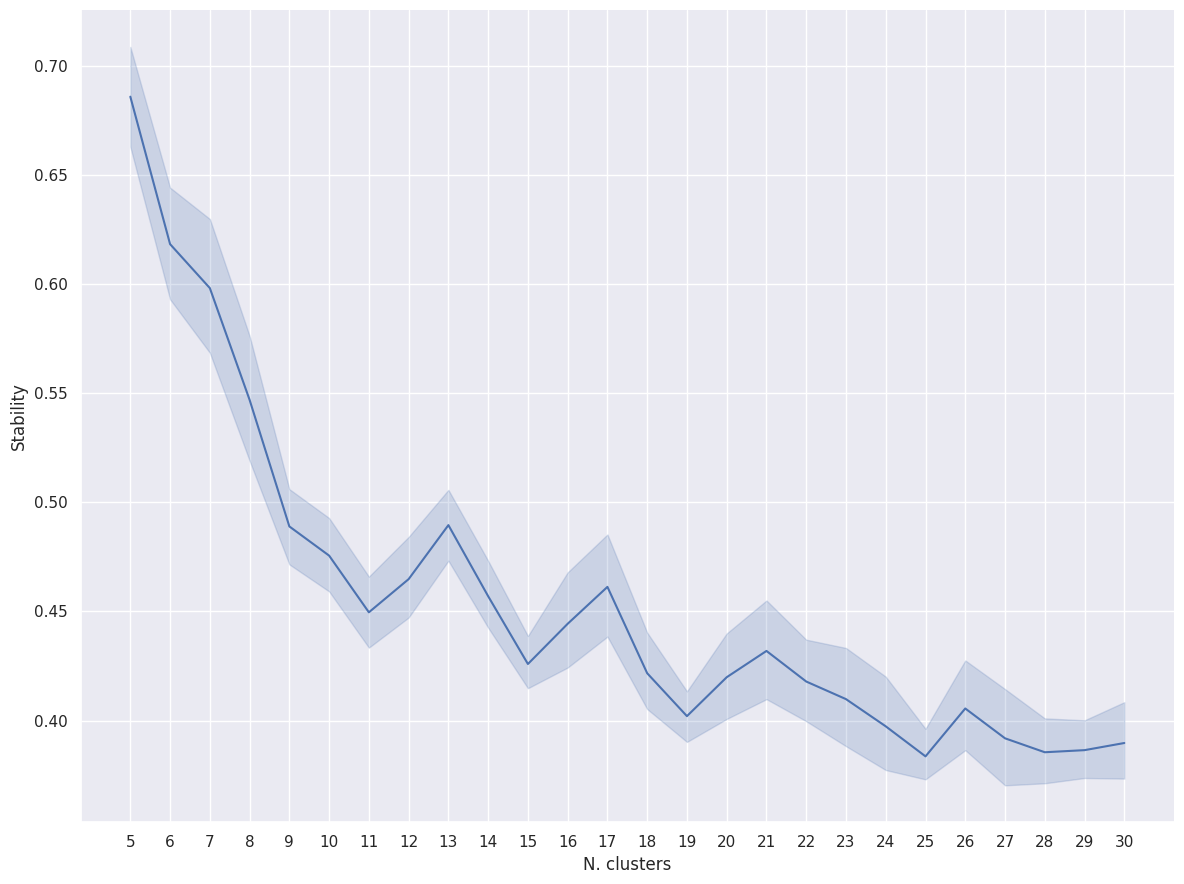

In [16]:
# Choose the best number of clusters with peaks of stability
cc.pl.autok_stability(model)
plt.tight_layout()
plt.show()
plt.close()

In [17]:
best_cluster = model.best_k
print(f"In our case, {best_cluster} is the best candidate!")
train_anndata.obs['cluster_cellcharter'] = model.predict(train_anndata, use_rep='X_cellcharter', k=best_cluster)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In our case, 5 is the best candidate!


/usr/local/lib/python3.11/dist-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


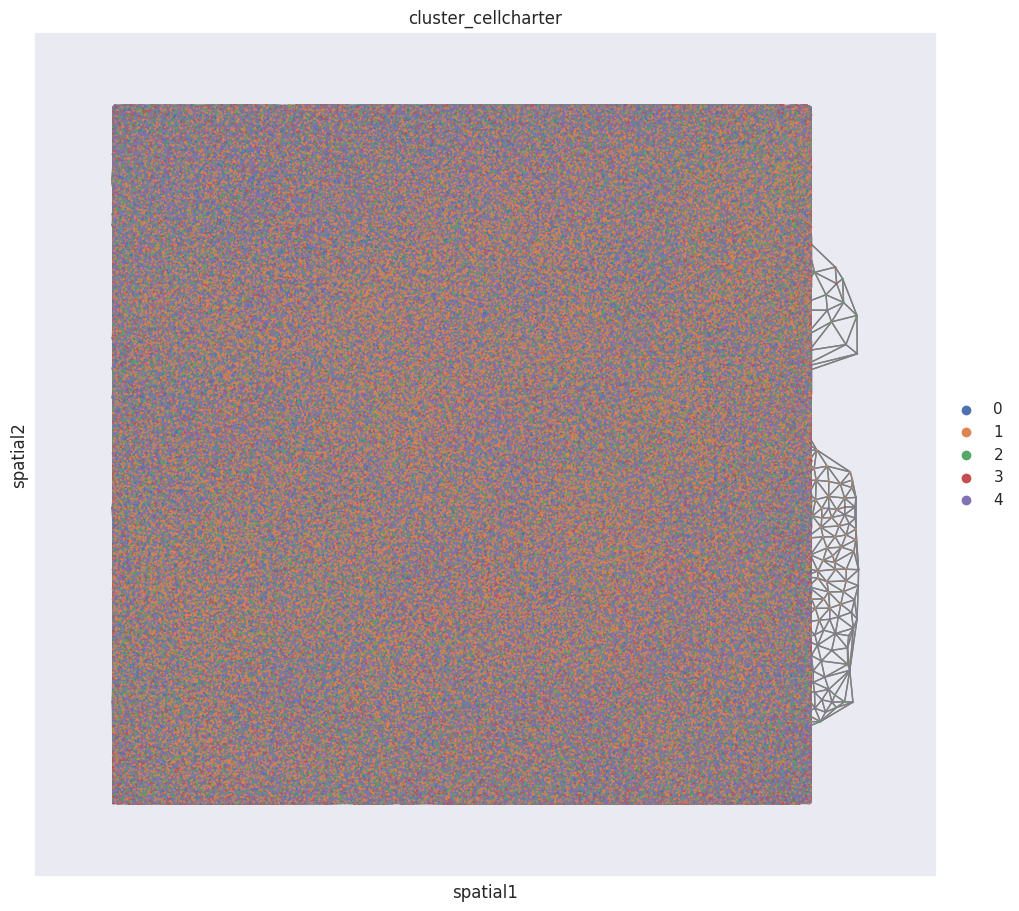

In [18]:
# Visualising the neighbourhood of clusters
sq.pl.spatial_scatter(train_anndata,
                      shape=None,
                      color='cluster_cellcharter',
                      connectivity_key='spatial_connectivities'
)

The results of our experiment:

**best_k** = 5, which is the number of clusters where clustering is most stable and biologically meaningful. We chose this information by training the GMM model for each k in a given range (4, 32) and comparing which value gives the best reproducible splits. We then used the estimated number of clusters to predict labels on the full set.

# Cluster Analysis

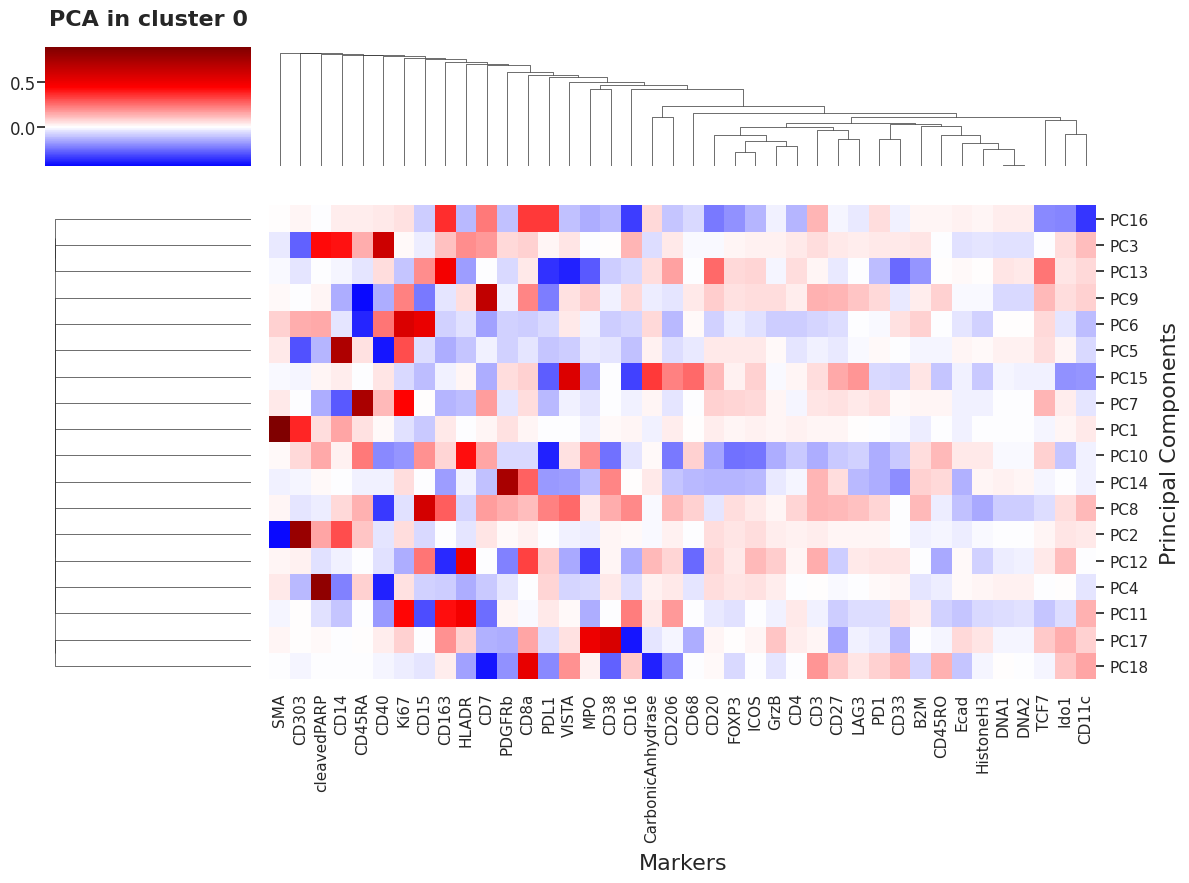

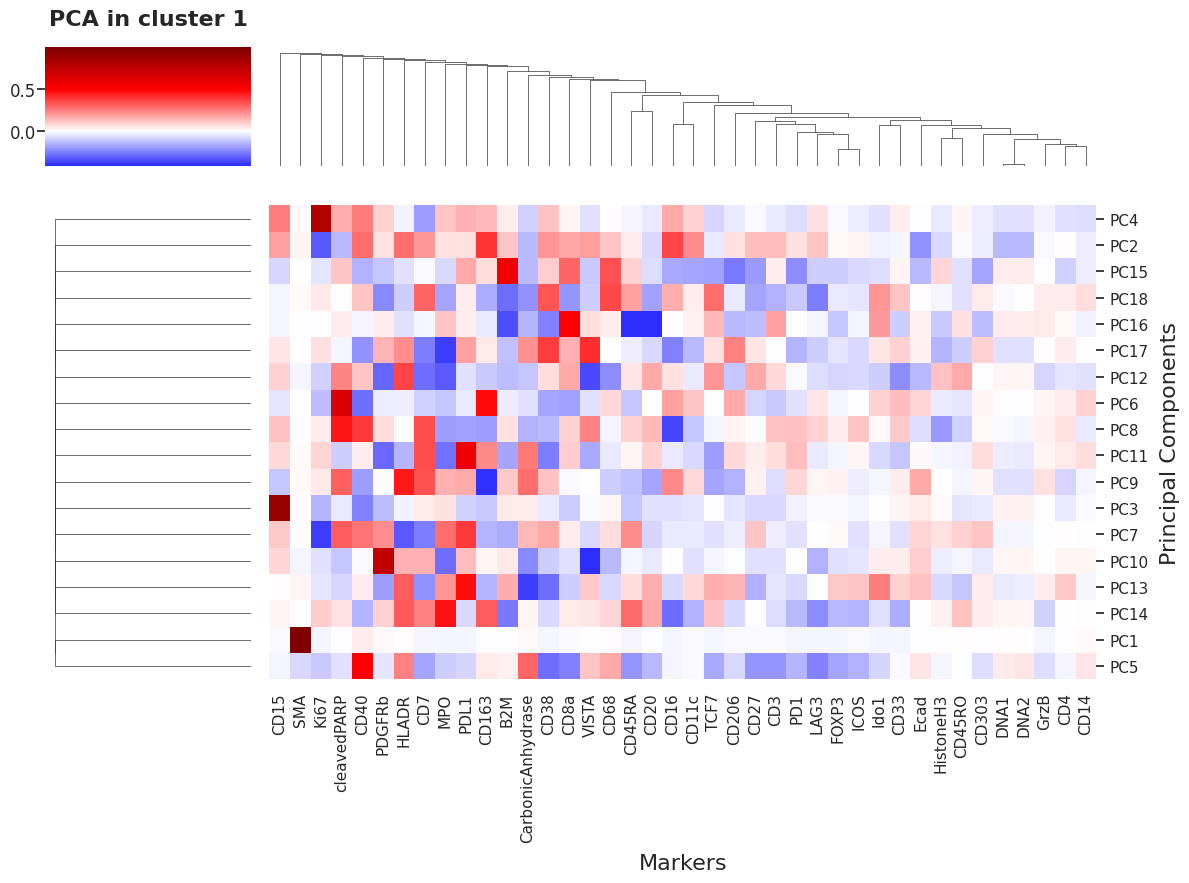

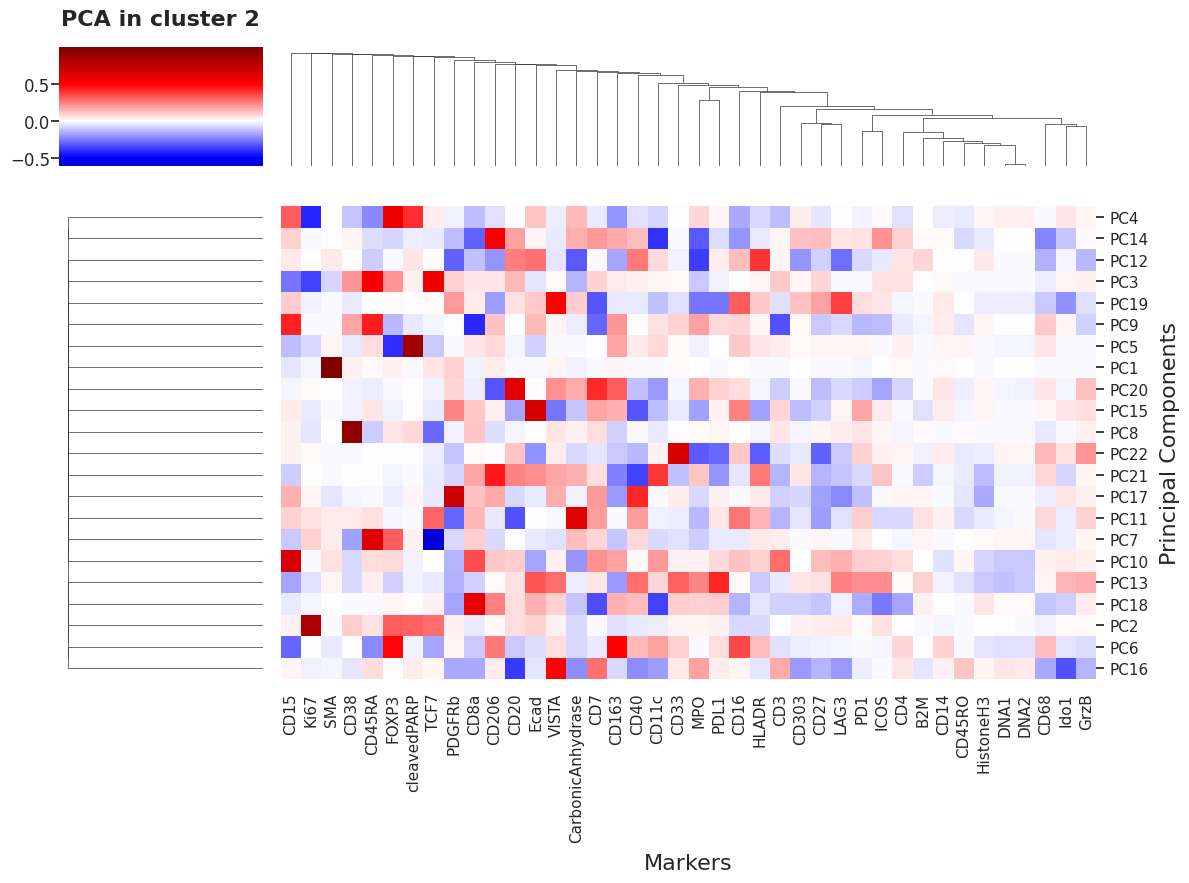

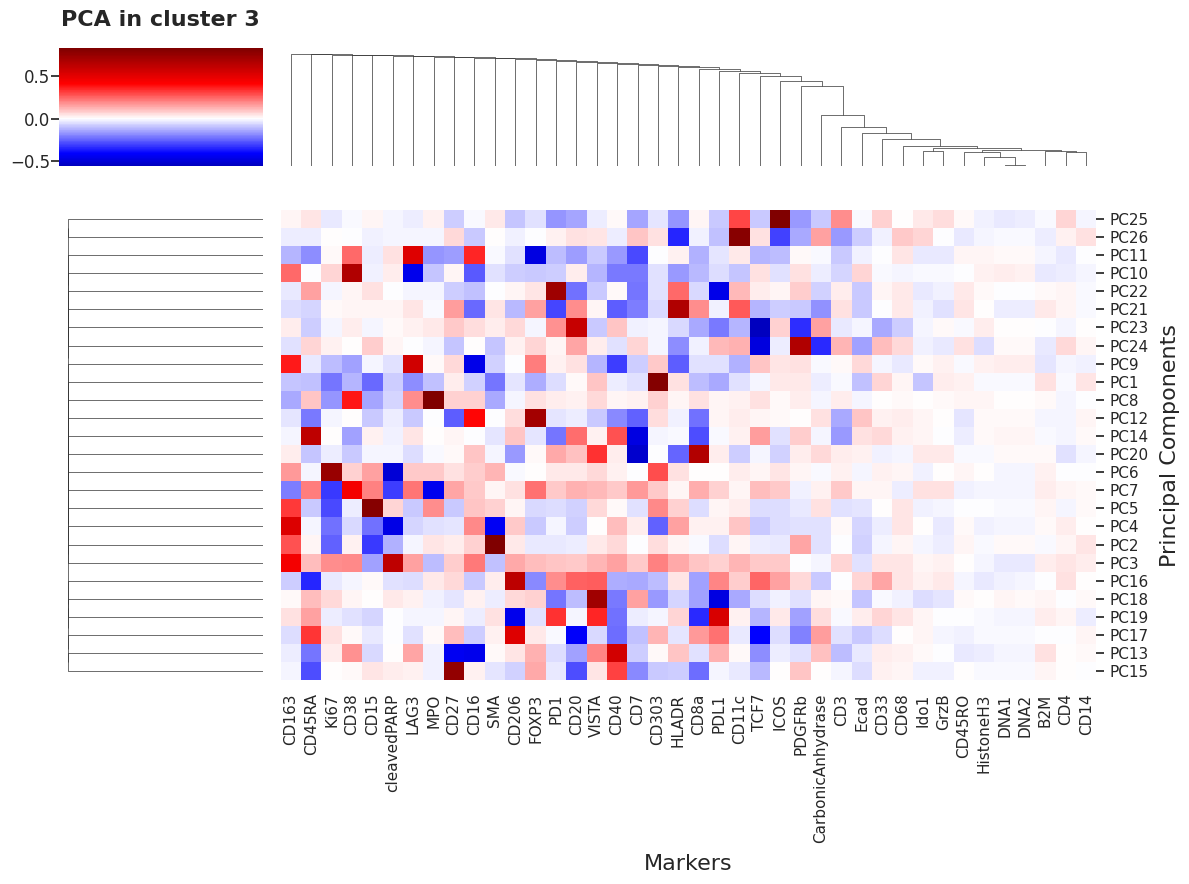

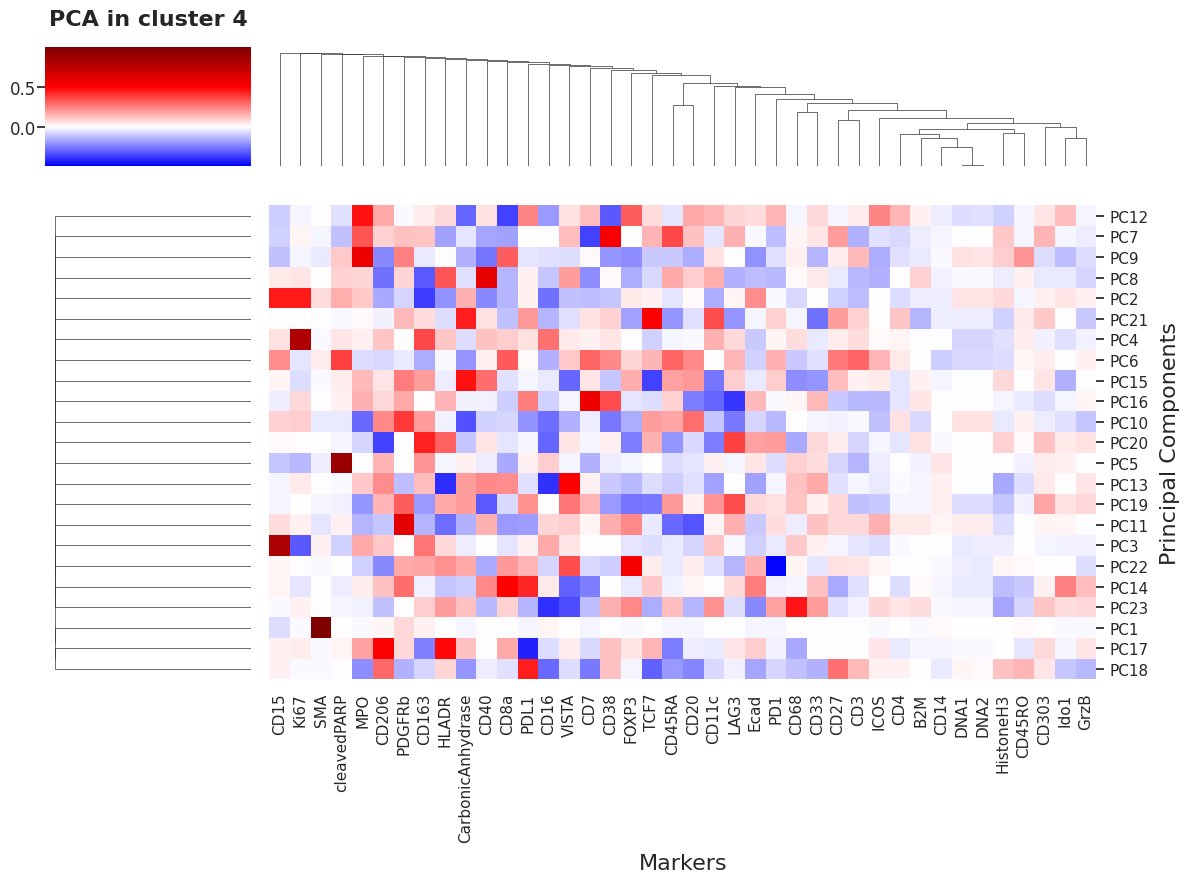

In [19]:
# PCA
for cluster in range(best_cluster):
    # For each cluster
    mask = train_anndata.obs['cluster_cellcharter'] == cluster
    cluster_data = train_anndata.layers['normalised_exprs'][mask, :]

    if cluster_data.shape[0] > 1:
        cluster_pca_model = PCA(n_components=0.95, svd_solver='full')
        cluster_pca_exprs = cluster_pca_model.fit_transform(cluster_data)

        # Visualization
        plot_clustermap(cluster_pca_model.components_,
                        train_anndata.var['marker'],
                        cluster_pca_exprs.shape[1],
                        f'PCA in cluster {cluster}'
        )
    else:
        print(f"Cluster {cluster} has only one cell, skipping PCA.")

As we can see in the heat maps above for each cluster, the level of markers varies, but the general nature of the data is maintained. Our previous observations carry over to each individual cluster, meaning that the sanity control was successful. In addition, we needed fewer components to explain 95% of the variance for each cluster separately, showing the effectiveness of cell clustering and that the clusters cluster cells with a more similar profile than the overall data.

In [20]:
def plot_heatmap(data: pd.DataFrame,
                 title: str,
                 fmt: str,
                 figsize: tuple = None,
                 xlabel: str = "Cell Types") -> None:
    """ Helper function for plotting heatmap.
    """
    if figsize:
        plt.figure(figsize=figsize)
        sns.heatmap(data, annot=True, fmt=fmt, cmap=sns.cubehelix_palette(as_cmap=True))
    else:
        plt.figure(figsize=plt.rcParams['figure.figsize'])
        sns.heatmap(data, annot=True, fmt=fmt, cmap="crest")

    plt.title(title, weight='bold', fontsize=20, pad=12)
    plt.xlabel(xlabel, fontsize=16, labelpad=8)
    plt.ylabel("Clusters", fontsize=16, labelpad=8)
    plt.tight_layout()
    plt.show()
    plt.close()

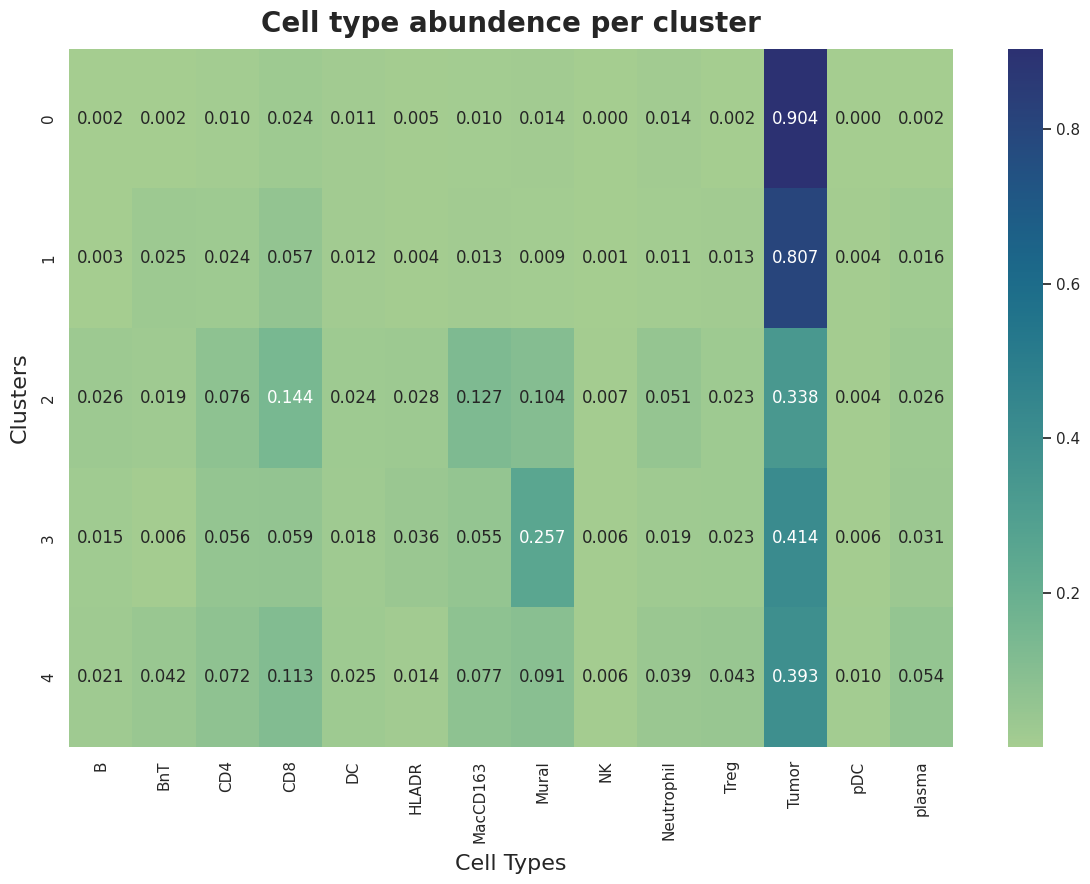

In [21]:
# Cell type abundance
cell_type_abundance = train_anndata.obs.groupby('cluster_cellcharter', observed=True)['celltypes']\
                      .value_counts(normalize=True).unstack()
plot_heatmap(cell_type_abundance, "Cell type abundence per cluster", ".3f")

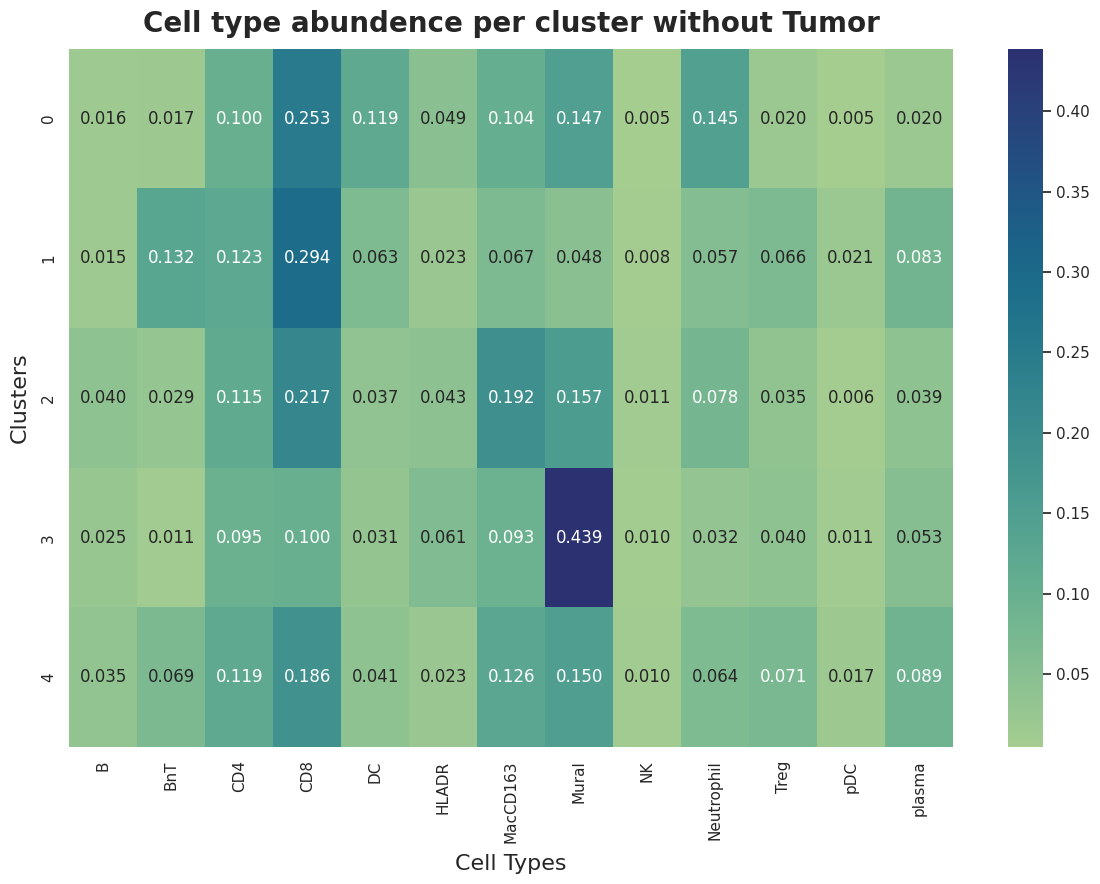

In [22]:
# Cell type abundance without Tumor
cell_type_abundance = train_anndata.obs.groupby('cluster_cellcharter', observed=True)['celltypes']\
                      .value_counts().unstack()
cell_type_abundance.drop(columns=['Tumor'], inplace=True)
cell_type_abundance = cell_type_abundance.div(cell_type_abundance.sum(axis=1), axis=0)
plot_heatmap(cell_type_abundance, "Cell type abundence per cluster without Tumor", ".3f")

Each row is a cluster (0,1,...,best_k-1) and each column is a given cell type (we excluded cells of type *Tumor* because they dominated each cluster). The values in each field are the percentage of that cell type within the cluster. From this analysis we can determine the characteristic presence of certain cells. The presence of **Mural** cells in the third cluster indicates areas close to blood vessels. In cluster one, on the other hand, there is a higher percentage of **CD8** cells, whose presence correlates with the immune response to the tumour.

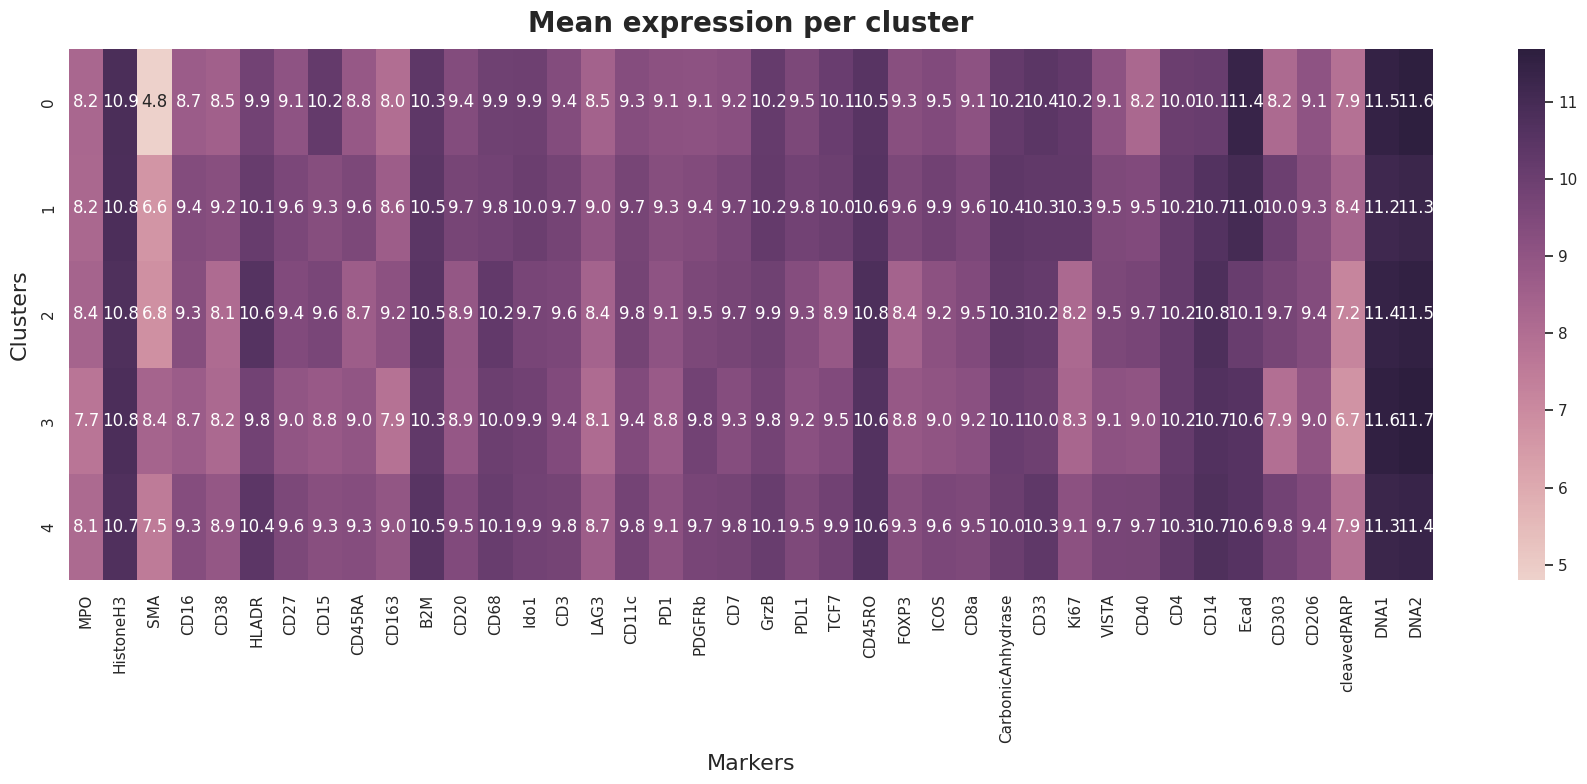

In [25]:
# Mean marker analysis
clusters_exprs = []

for cluster in range(best_cluster):
    # For each cluster
    mask = train_anndata.obs['cluster_cellcharter'] == cluster
    cluster_data = train_anndata.layers['normalised_exprs'][mask, :]
    clusters_exprs.append(cluster_data.mean(axis=0))

# Make DataFrame to plot
expressions_clusters_df = pd.DataFrame(
    np.stack(clusters_exprs),
    columns=train_anndata.var['marker'],
    index=[f'{i}' for i in range(best_cluster)]
)

plot_heatmap(expressions_clusters_df, "Mean expression per cluster", ".1f", (18, 8), "Markers")

In the heatmap above rows are clusters, columns are individual markers. Each cell in the matrix is the average (normalised) expression of a given marker in a given cluster. Higher values (darker boxes) indicate which markers are more highly expressed in a given cluster. We can see that general markers, such as the previously observed **DNA1** and **DNA2**, are present in high numbers in each cluster due to their general nature and attach to each cell, as does the **HistoneH3** marker. Another notable marker is **SMA**, which is responsible for identifying pericytes and smooth muscle cells on blood vessels in tissues. Its high expression often indicates the presence of tumour stroma activated by fibroblasts and pericytes. Its presence can be correlated with the **Mural** cell type.

# Cross-count Matrices

In [26]:
# Clearing memory and RAM
gc.collect()

1111457

In [27]:
# Neighbourhood matrix
adj = train_anndata.obsp['spatial_connectivities']
adj_self = adj + sp.eye(adj.shape[0], format='csr')

# Mean exprresion of markers in neighbourhood
expr_norm = train_anndata.layers['normalised_exprs']
total_expr = adj_self.dot(expr_norm)
degrees = np.ravel(adj_self.sum(axis=1))
mean_markers_expression = total_expr / degrees[:, None]
train_anndata.obsm['mean_markers_expression'] = mean_markers_expression.astype(np.float32)

# Histogram of cells by one-hot encoding
a_celltypes = pd.Categorical(train_anndata.obs['celltypes'])
onehot = pd.get_dummies(a_celltypes).values
celltype_hist = adj_self.dot(onehot)
train_anndata.obsm['cell_type_hist'] = celltype_hist.astype(np.float32)

model_mean = cc.tl.ClusterAutoK(
    n_clusters=n_clusters,
    model_class=cc.tl.GaussianMixture,
    model_params=model_params,
    max_runs=8
)
model_hist = cc.tl.ClusterAutoK(
    n_clusters=n_clusters,
    model_class=cc.tl.GaussianMixture,
    model_params=model_params,
    max_runs=8
)

In [29]:
def make_cross_matrix(obs, col1, col2, normalize=True):
    """ Function returns a DataFrame with a
    cross-sectional matrix and percentages.
    """
    ct = pd.crosstab(obs[col1], obs[col2])
    if normalize:
        ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
        return ct, ct_pct

    return ct, None


def plot_cross_heatmap(ct_raw, ct_pct, title):
    """ Function plots a heatmap of a cross-count matrix.
    """
    plt.figure(figsize=plt.rcParams['figure.figsize'])
    ax = sns.heatmap(
        ct_raw,
        annot=False,
        fmt='d',
        cmap='YlOrBr',
        cbar_kws={'label': 'Number of Cells', 'pad': 0.05}
    )

    for i in range(ct_raw.shape[0]):
        for j in range(ct_raw.shape[1]):
            raw = ct_raw.iloc[i, j]
            pct = ct_pct.iloc[i, j]
            color = 'white' if raw >= 37000 else 'black' # Clear, displayed colour
            ax.text(
                j + 0.5, i + 0.4,
                f"{raw}",
                ha='center', va='center',
                color=color,
                fontsize=12, weight='bold'
            )
            ax.text(
                j + 0.5, i + 0.6,
                f"({pct:.1f}%)",
                ha='center', va='center',
                color=color,
                fontsize=8
            )

    ax.set_title(title, fontsize=16, pad=12, weight='bold')
    ax.set_xlabel(ct_raw.columns.name or '', fontsize=12)
    ax.set_ylabel(ct_raw.index.name or '', fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.close()

In [30]:
model_mean.fit(train_anndata[::10], use_rep='mean_markers_expression')
model_hist.fit(train_anndata[::10], use_rep='cell_type_hist')

Iteration 1/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 2/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 3/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 4/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 5/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 6/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 7/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 8/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 1/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 2/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 3/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 4/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 5/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 6/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 7/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

Iteration 8/8


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Best k (mean expression): 5, Best k (hist): 5


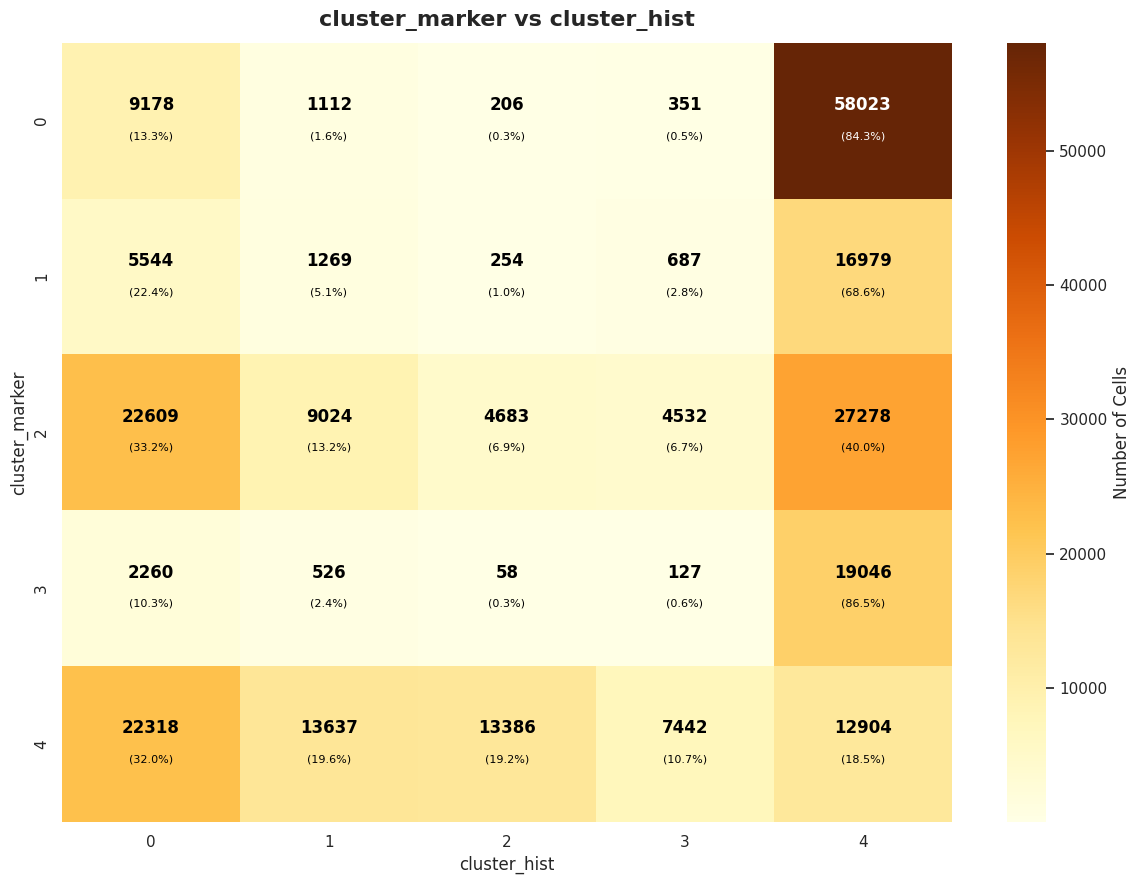

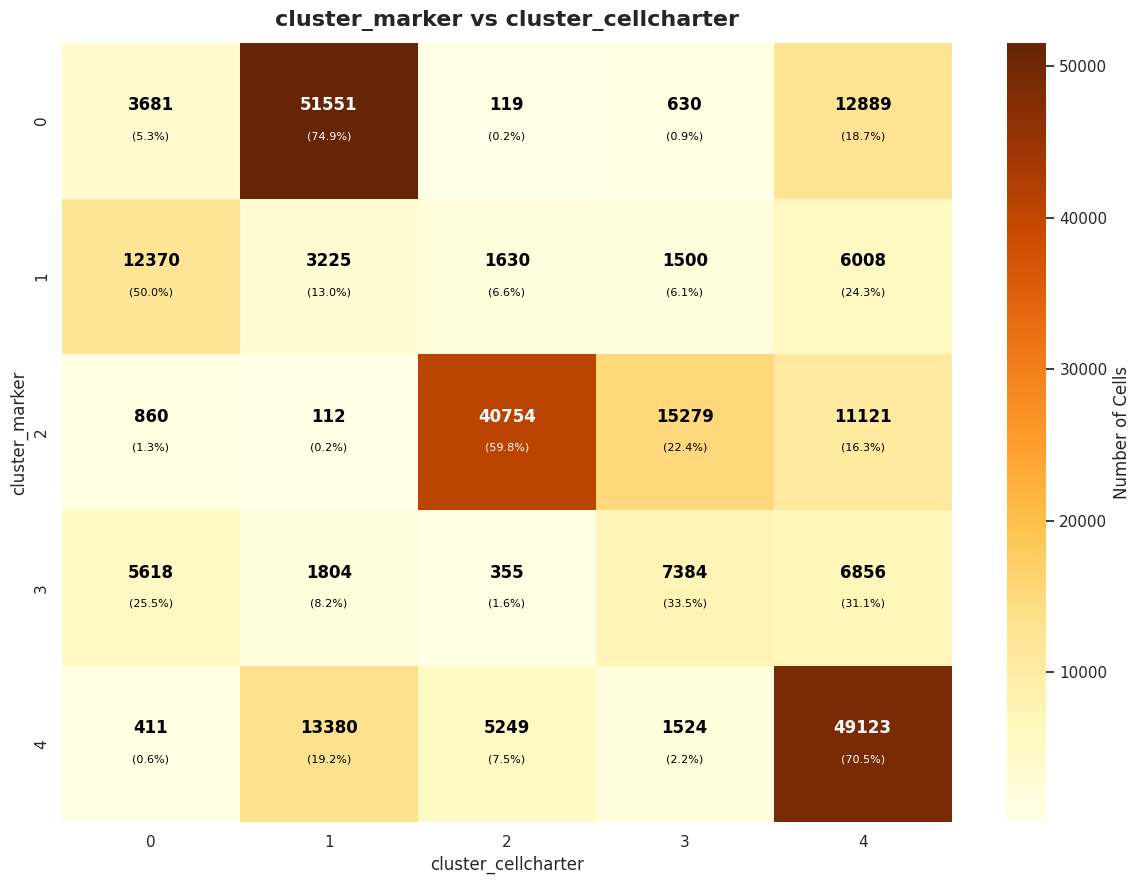

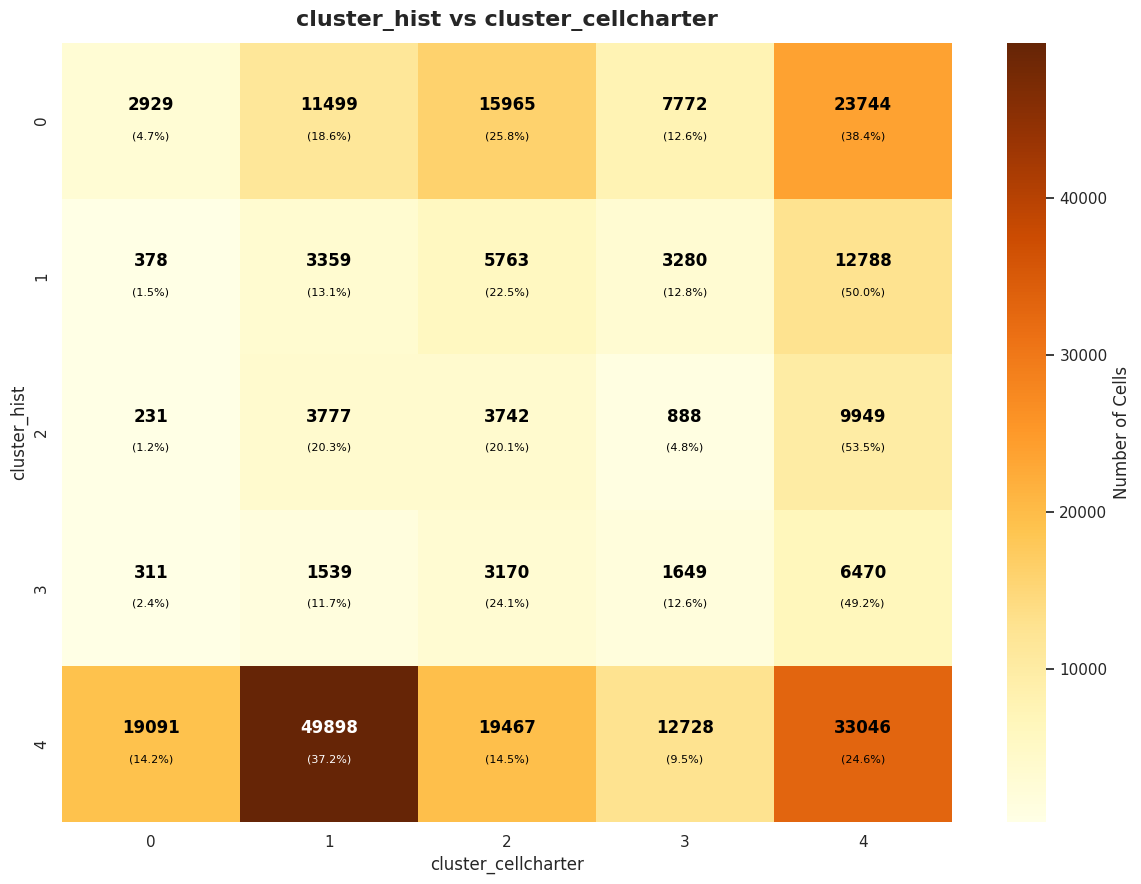

In [33]:
# Best k for each model
n_best_mean = model_mean.best_k
n_best_hist = model_hist.best_k
print(f"Best k (mean expression): {n_best_mean}, Best k (hist): {n_best_hist}")

train_anndata.obs['cluster_marker'] = model_mean.predict(train_anndata, use_rep='mean_markers_expression', k=n_best_mean)
train_anndata.obs['cluster_hist']   = model_hist.predict(train_anndata, use_rep='cell_type_hist', k=n_best_hist)

# Comparison of clustering
for name_a, name_b in [('cluster_marker','cluster_hist'), ('cluster_marker','cluster_cellcharter'), ('cluster_hist','cluster_cellcharter')]:
    ct_raw, ct_pct = make_cross_matrix(train_anndata.obs, name_a, name_b)
    plot_cross_heatmap(ct_raw, ct_pct, f"{name_a} vs {name_b}")

The results obtained above, correspond:

* Average expression of markers (**cluster_marker**)

* Histogram of cell types (**cluster_hist**)

* CellCharter on spatial embedding (**cluster_cellcharter**)

All three models - clustering based on mean marker expression, cell type histograms and spatial embedding in CellCharter - consistently identified five clusters, indicating a similar complexity of the problem and a clear separation of the data into five populations. The strongest agreement was observed between marker and histogram clustering, mainly due to the dominant presence of cancer cells in the fourth histogram cluster. The good agreement (around 60%) between the mean expression and the spatial approach suggests that the molecular signals overlap with the location context, especially for the main populations.

On the other hand, the weakest correspondence between the cell type histograms and the spatial embedding indicates that the immunological distribution does not always correlate with the immediate cellular neighbourhood in the tissue. For a more detailed analysis, the minimum number of clusters could be increased or a hierarchical approach could be introduced: isolating five main clusters and then deepening the analysis within them. Such a strategy would identify more subtle subpopulations of potential biological significance.